# TASK_1: Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; 

### Test for CUDA( you can use either GPU or CPU as you like )

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda" if train_on_gpu else "cpu")

CUDA is available!  Training on GPU ...


---
## Load the Data

If you're not familiar with the Cifar-10, you may find it useful to look at: http://www.cs.toronto.edu/~kriz/cifar.html . Or you could search it by yourself. 

You can load the dataset through **datasets.CIFAR10** in **torchvision**.


#### TODO: Load the data

In [2]:
# # To avoid ssl.SSLCertVerificationError
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


1. 首先需要构建dataset，构建dataset时可以利用transforms做数据增强，在这里采用了对CIFAR-10数据集常用的数据增强方法：随机裁剪和水平翻转，以及normalize操作。
transforms并不是直接扩充样本量，而是各种变换以一定概率直接作用在原图片上，没有生成新样本，只不过在一次次迭代过程中，各种变换随机发生，从而导致每次Epoch读进来的数据都是不一样的，从大数定理的角度相当于扩充了样本量。


2. 将dataset传入到dataloader中，后续训练和测试通过enumerate dataloader来喂数据。

trainset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
testset: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
torch.Size([3, 32, 32])
frog


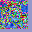

In [3]:
# View the dataset info and transformed image example
print('trainset:', trainset)
print('testset:', testset)

print(trainset.classes)
print(trainset[0][0].shape)
print(trainset.classes[trainset[0][1]])
transform_toimg = transforms.ToPILImage()
img = transform_toimg(trainset[0][0])
img.show()


---
## Define the Network Architecture

This time, you'll define a CNN architecture. You may use 
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.


#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation:
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

#### TODO: Define a model with multiple convolutional layers and an output layer for image classification

In [14]:
#Define a CNN model

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class CnnNet(nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(6 * 6 * 128, 128)
        self.dropout3 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

model = CnnNet()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# test
def test_CnnNet():
    model = CnnNet()
    y = model(torch.randn(10, 3, 32, 32))
    print('test output size:\n', y.size())
test_CnnNet()

CnnNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
test output size:
 torch.Size([10, 10])


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. Pay attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer 

In [15]:
import torch.optim as optim

lr = 1.0    # Note the default learning rate for optimizer Adadelta is 1.0
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


1. CrossEntropyLoss等于对输出做F.log_softmax(x, dim=1)再做nll_loss，注意对应的target都不是one-hot类型的。
2. 暂定训练200个epoch，学习率余弦退火。

---
## Train the Network

Remember to look at how the loss decreases over time and print them.

需要使用tensorboard观察train loss。

In [17]:
from tensorboardX import SummaryWriter

def train(model, device, trainloader, criterion, optimizer, epoch, writer, log_interval):
    model.train()
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('Train Loss', loss, (epoch - 1) * len(trainloader) + batch_idx)

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

# set the max training epoch and log_interval(for train loss printing interval)
# initialize the writer
epoch = 200
log_interval = 100
writer = SummaryWriter(log_dir='runs/CnnNet')

# start train
for epoch in range(1, epoch + 1):
    train(model, device, trainloader, criterion, optimizer, epoch, writer, log_interval)
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.313801
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.435543
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.258914
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.220180
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.197856
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.248019
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.174956
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.147141
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.145261
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.152931
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.169389
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.171086
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.220663
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.200388
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.160090
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.008212
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.083390
Train Epoch: 5 [12800/50000 (26%)]	Loss: 0.973850
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.242392
Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.105383
Train Epoch: 6 [0/50000 (

---
## Test the Trained Network

Test your trained model on previously unseen data and print the test accuracy of each class and the whole! Try your best to get a better accuracy.

In [22]:
def test(model, device, testloader, criterion, epoch, writer):
    model.eval()
    test_loss = 0
    correct = 0
    
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    N_CLASSES = 10
    class_correct = list(0. for i in range(N_CLASSES))
    class_total = list(0. for i in range(N_CLASSES))
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(testloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            
            _, pred = output.max(dim=1)
            correct += pred.eq(target).sum().item()

            c = (pred == target).squeeze()
            for i in range(len(target)):
                _target = target[i]
                class_correct[_target] += c[i].item()
                class_total[_target] += 1


    test_loss /= len(testloader.dataset)

    # writer.add_scalar('Test Loss', test_loss, epoch - 1)
    # writer.add_scalar('Test Accuracy', 100. * correct / len(testloader.dataset), epoch - 1)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
    for i in range(N_CLASSES):
        print('\nTest set: Accuracy of {:5s}: {}/{} ({:.0f}%)\n'.format(
        classes[i], class_correct[i], class_total[i],
        100. * class_correct[i] / (class_total[i]+1)))

# start test
test(model, device, testloader, criterion, epoch=200, writer=writer)



Test set: Average loss: 0.0037, Accuracy: 8753/10000 (88%)


Test set: Accuracy of airplane: 883.0/1000.0 (88%)


Test set: Accuracy of automobile: 929.0/1000.0 (93%)


Test set: Accuracy of bird : 790.0/1000.0 (79%)


Test set: Accuracy of cat  : 740.0/1000.0 (74%)


Test set: Accuracy of deer : 890.0/1000.0 (89%)


Test set: Accuracy of dog  : 827.0/1000.0 (83%)


Test set: Accuracy of frog : 946.0/1000.0 (95%)


Test set: Accuracy of horse: 887.0/1000.0 (89%)


Test set: Accuracy of ship : 933.0/1000.0 (93%)


Test set: Accuracy of truck: 928.0/1000.0 (93%)



---
# TASK_2: Resnet18
---
Since you have completed the simple convolutional neural networks, now we are going to construct a widely used model ResNet.
In this task, we choose the **Resnet18** to classify images from the CIFAR-10 database.

You are supposed to design the network architecture by yourself. DO NOT directly call the resent module 'torchvision.models.resnet' in pytorch.

Now define the network and train it!

In [2]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda" if train_on_gpu else "cpu")

CUDA is available!  Training on GPU ...


In [3]:
# # To avoid ssl.SSLCertVerificationError
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

# define the model ResNet-18
model = ResNet(BasicBlock, [2, 2, 2, 2])
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
    device_ids = [0, 1, 2, 3, 4, 5]
    model = nn.DataParallel(model, device_ids=device_ids)   #multigpu

# test
def test_ResNet18():
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    y = model(torch.randn(10, 3, 32, 32))
    print('test output size:\n', y.size())
test_ResNet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [7]:
import torch.optim as optim
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

lr = 1.0    # Note the default learning rate is 1.0
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

from tensorboardX import SummaryWriter

def train(model, device, trainloader, criterion, optimizer, epoch, writer, log_interval):
    model.train()
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('Train Loss', loss, (epoch - 1) * len(trainloader) + batch_idx)

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

# set the max training epoch and log_interval(for train loss printing interval)
# initialize the writer
epoch = 200
log_interval = 100
writer = SummaryWriter(log_dir='runs/ResNet-18')

# start train
for epoch in range(1, epoch + 1):
    train(model, device, trainloader, criterion, optimizer, epoch, writer, log_interval)
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.535027
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.879644
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.589144
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.530121
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.602720
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.267005
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.367409
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.128361
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.069958
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.978888
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.906385
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.183850
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.932122
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.676753
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.860034
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.713821
Train Epoch: 5 [0/50000 (0%)]	Loss: 0.570484
Train Epoch: 5 [12800/50000 (26%)]	Loss: 0.957704
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.614042
Train Epoch: 5 [38400/50000 (77%)]	Loss: 0.691579
Train Epoch: 6 [0/50000 (

In [9]:
def test(model, device, testloader, criterion, epoch, writer):
    model.eval()
    test_loss = 0
    correct = 0
    
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    N_CLASSES = 10
    class_correct = list(0. for i in range(N_CLASSES))
    class_total = list(0. for i in range(N_CLASSES))
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(testloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            
            _, pred = output.max(dim=1)
            correct += pred.eq(target).sum().item()

            c = (pred == target).squeeze()
            for i in range(len(target)):
                _target = target[i]
                class_correct[_target] += c[i].item()
                class_total[_target] += 1


    test_loss /= len(testloader.dataset)

    # writer.add_scalar('Test Loss', test_loss, epoch - 1)
    # writer.add_scalar('Test Accuracy', 100. * correct / len(testloader.dataset), epoch - 1)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
    for i in range(N_CLASSES):
        print('\nTest set: Accuracy of {:5s}: {}/{} ({:.0f}%)\n'.format(
        classes[i], class_correct[i], class_total[i],
        100. * class_correct[i] / (class_total[i]+1)))

# start test
test(model, device, testloader, criterion, epoch=200, writer=writer)



Test set: Average loss: 0.0043, Accuracy: 9383/10000 (94%)


Test set: Accuracy of airplane: 941.0/1000.0 (94%)


Test set: Accuracy of automobile: 974.0/1000.0 (97%)


Test set: Accuracy of bird : 927.0/1000.0 (93%)


Test set: Accuracy of cat  : 859.0/1000.0 (86%)


Test set: Accuracy of deer : 947.0/1000.0 (95%)


Test set: Accuracy of dog  : 894.0/1000.0 (89%)


Test set: Accuracy of frog : 957.0/1000.0 (96%)


Test set: Accuracy of horse: 960.0/1000.0 (96%)


Test set: Accuracy of ship : 964.0/1000.0 (96%)


Test set: Accuracy of truck: 960.0/1000.0 (96%)

